In [1]:
import os, sys
import glob as glob
import numpy as np
import logging
import warnings
import pickle
import MDAnalysis as mda
from pprint import pprint

#from openeye import oechem
from openff.qcsubmit.common_structures import QCSpec, PCMSettings, DriverEnum, SCFProperties
from openff.qcsubmit.factories import OptimizationDatasetFactory, BasicDatasetFactory
from openff.qcsubmit.workflow_components import ComponentResult
from openff.toolkit.topology import Molecule
from qcelemental.models.results import WavefunctionProtocolEnum
from tqdm import tqdm

In [2]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit import rdBase
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.drawOptions.addStereoAnnotation = True

print(rdBase.rdkitVersion)

2022.03.3


In [3]:
from openff.toolkit._version import get_versions
get_versions()

{'date': '2022-04-25T11:55:39-0400',
 'dirty': False,
 'error': None,
 'full-revisionid': '37d6806bbb9d0d8aacb7221891b5d86dcdee014b',
 'version': '0.10.6'}

In [4]:
# Warnings that tell us we have undefined stereo and charged molecules
logging.getLogger("openff.toolkit").setLevel(logging.ERROR)
warnings.simplefilter("ignore")

In [5]:
from openff.toolkit.utils import GLOBAL_TOOLKIT_REGISTRY
from openff.toolkit.utils import OpenEyeToolkitWrapper, RDKitToolkitWrapper, AmberToolsToolkitWrapper, BuiltInToolkitWrapper
#GLOBAL_TOOLKIT_REGISTRY.deregister_toolkit(OpenEyeToolkitWrapper)
#GLOBAL_TOOLKIT_REGISTRY.deregister_toolkit(RDKitToolkitWrapper)
#GLOBAL_TOOLKIT_REGISTRY.deregister_toolkit(AmberToolsToolkitWrapper)
#GLOBAL_TOOLKIT_REGISTRY.deregister_toolkit(BuiltInToolkitWrapper)

print(GLOBAL_TOOLKIT_REGISTRY.registered_toolkits)

[ToolkitWrapper around The RDKit version 2022.03.3, ToolkitWrapper around AmberTools version 22.0, ToolkitWrapper around Built-in Toolkit version None]


# Dataset Preparation

#### Case 1) load pdb exported from openmm minimization
https://github.com/openforcefield/openff-toolkit/issues/1126#issuecomment-969712195  
https://docs.mdanalysis.org/stable/documentation_pages/converters/RDKit.html?highlight=rdkit#module-MDAnalysis.converters.RDKit

In [94]:
#files = glob.glob("sample/AAA/*.pdb")   # success (2 inchikey)
files = glob.glob("sample/GGG/*.pdb")   # fail (2 inchikey)
#files = glob.glob("sample/CCC/*.pdb")   # success (1 inchikey)
#files = glob.glob("sample/UUU/*.pdb")   # success (1 inchikey)
#files = glob.glob("sample/GCC/*.pdb")   # fail (1 inchikey)
print(len(files))


rdmols = []
for file in tqdm(files):
    basename = os.path.basename(file).split('.pdb')[0]
    u = mda.Universe(file)
    u.add_TopologyAttr("elements", u.atoms.types)
    rdmol = u.atoms.convert_to("RDKIT")  # preserves atom order
    rdmol.SetProp('_Name', basename)
    rdmols.append(rdmol)
    
assert len(files) == len(rdmols)


#with open('rdmols.pkl', 'wb') as pkl:
#     pickle.dump(rdmols, pkl, protocol=4)
#with open('rdmols.pkl', 'rb') as db:
#    rmdols_pkl = pickle.load(db)

48


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:31<00:00,  1.50it/s]


#### Case 2) load sdf prepared by schrodinger software (pdbconvert: pdb -> mae / canvasConvert: mae -> sdf)

check for unassigned stereochemistry

In [95]:
for i, rdmol in enumerate(rdmols):
    x = Chem.FindMolChiralCenters(rdmol, force=True, includeUnassigned=True, useLegacyImplementation=False)
    #print(x)
    q = [ s for s in x if s[1] == "?" ]
    if len(q) != 0:
        print("{}: {} ({})".format(i, rdmol.GetProp('_Name'), q))        

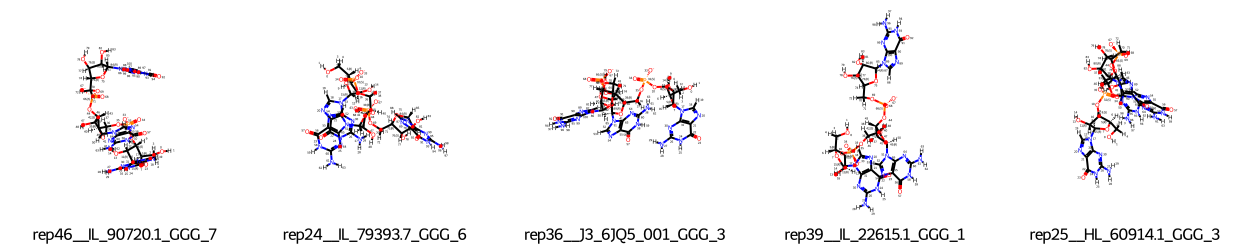

In [96]:
_rdmols = rdmols[:5]
Draw.MolsToGridImage(_rdmols, subImgSize=(250,250), molsPerRow=5, legends=[ r.GetProp('_Name') for r in _rdmols ])

load all molecules

In [97]:
mols = [ Molecule.from_rdkit(rdmol, allow_undefined_stereo=False, hydrogens_are_explicit=True) for rdmol in tqdm(rdmols) ]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:03<00:00, 15.01it/s]


In [98]:
#mols[0].visualize()

In [99]:
#Molecule.to_smiles(mols[0])

check inchikey

Prepare the main dataset from the molecule list.
`dataset_factory` parameters taken from [2021-11-15-QMDataset-DES-monomers-single-points](https://github.com/openforcefield/qca-dataset-submission/tree/master/submissions/2021-11-15-QMDataset-DES-monomers-single-points).

In [100]:
factory = BasicDatasetFactory(driver=DriverEnum.gradient, 
                              qc_specifications={ 'default': QCSpec(method='wb97m-d3bj', 
                                                                    basis='def2-tzvppd', 
                                                                    program='psi4', 
                                                                    spec_name='rna_default', 
                                                                    spec_description='RNA quantum chemistry specification', 
                                                                    store_wavefunction=WavefunctionProtocolEnum.orbitals_and_eigenvalues, 
                                                                    implicit_solvent=None, 
                                                                    maxiter=200, 
                                                                    scf_properties=[SCFProperties.Dipole, SCFProperties.Quadrupole, SCFProperties.WibergLowdinIndices, 
                                                                                    SCFProperties.MayerIndices, SCFProperties.MBISCharges], 
                                                                    keywords={'wcombine': False}) },
                             store_wavefunction=WavefunctionProtocolEnum.orbitals_and_eigenvalues)

In [101]:
dataset = factory.create_dataset(dataset_name="RNA Single Point Dataset v1.0", 
                                 molecules=mols, 
                                 tagline="QM dataset for ML", 
                                 description="Data source: https://github.com/kntkb/rna_bgsu")

Deduplication                 :  62%|██████▉    | 30/48 [00:00<00:00, 31.90it/s]


AssertionError: 

In [ ]:
for i, f in enumerate(files):
    print(i, f)

Make sure the molecules in the dataset match the input molecules

Describe the molecule in the dataset

Describe the dataset

Export the dataset.